In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [22]:
df = pd.read_csv("/kaggle/input/customer-segmentation/cleaned_data.csv")

Searching best k (sampled silhouette)...
 k=2  inertia=2534.6  sampled_sil=0.709
 k=3  inertia=1500.8  sampled_sil=0.480
 k=4  inertia=1218.3  sampled_sil=0.439
 k=5  inertia=956.1  sampled_sil=0.440
 k=6  inertia=741.1  sampled_sil=0.458
 k=7  inertia=622.0  sampled_sil=0.471
 k=8  inertia=547.5  sampled_sil=0.418

Selected best_k (by max sampled silhouette) = 2


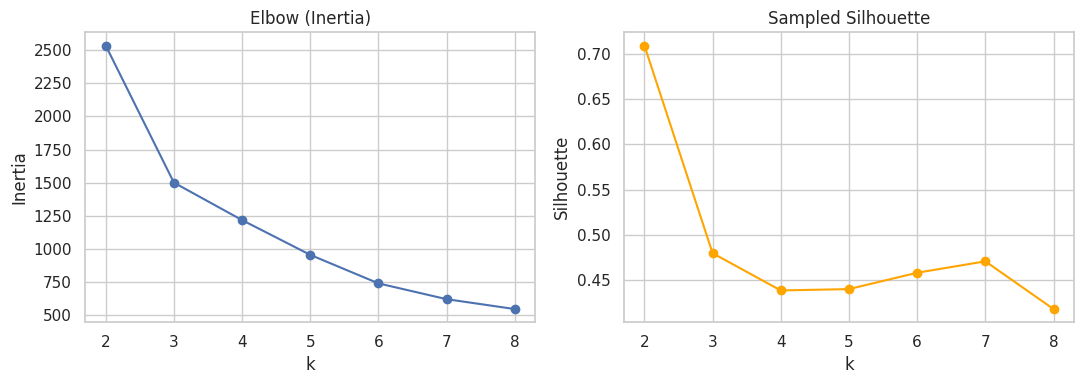


Cluster counts:
cluster
0    906
1     77
Name: count, dtype: int64


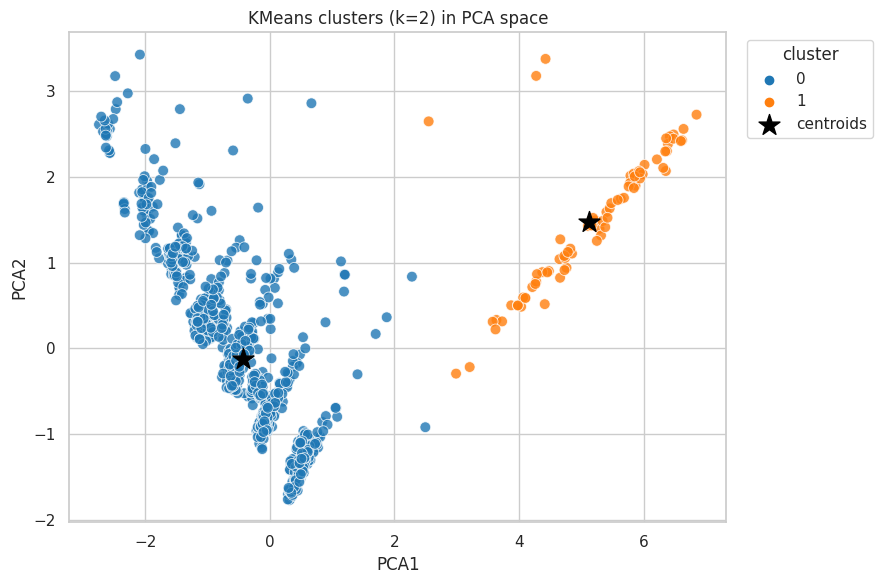

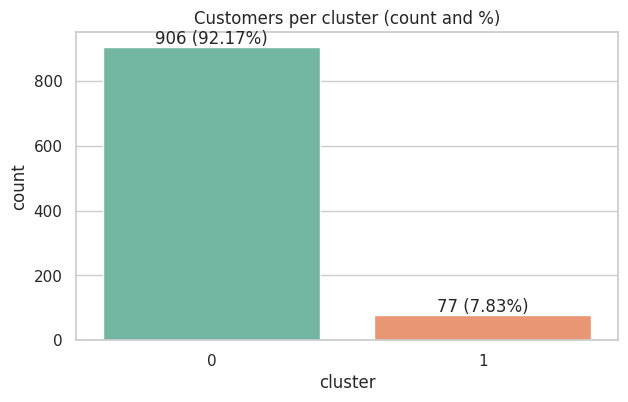


Mapped cluster labels to df — sample mapping counts:
cluster
0    1293895
1       2780
Name: count, dtype: int64

Saved /kaggle/working//agg_with_clusters.csv and a sample transactions CSV for review.


In [24]:
sns.set(style="whitegrid")

# 0) FEATURES TO USE (edit if you want different ones)
features = ['txn_count','total_spend','avg_spend','std_spend','recency_days']
features = [f for f in features if f in agg.columns]   # keep only existing columns
if len(features) < 2:
    raise ValueError("Not enough numeric features found in agg for clustering. Update `features` list.")

# 1) SCALE
scaler = StandardScaler()
X = agg[features].fillna(0)   # fill NA for safety
X_scaled = scaler.fit_transform(X)

# 2) FIND REASONABLE K (Elbow + sampled silhouette) - fast
K_range = range(2, 9)   # try k = 2..8
inertias, silhouettes = [], []
sample_size = min(3000, X_scaled.shape[0])
rng = np.random.default_rng(42)
sample_idx = rng.choice(X_scaled.shape[0], size=sample_size, replace=False)

print("Searching best k (sampled silhouette)...")
for k in K_range:
    km_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = km_temp.fit_predict(X_scaled)
    inertias.append(km_temp.inertia_)
    try:
        sil = silhouette_score(X_scaled[sample_idx], labels_temp[sample_idx])
    except Exception:
        sil = np.nan
    silhouettes.append(sil)
    print(f" k={k}  inertia={km_temp.inertia_:.1f}  sampled_sil={sil:.3f}")

best_k = int(K_range[np.nanargmax(silhouettes)])
print(f"\nSelected best_k (by max sampled silhouette) = {best_k}")

# OPTIONAL: plot elbow & silhouette
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(list(K_range), inertias, marker='o')
plt.title("Elbow (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(list(K_range), silhouettes, marker='o', color='orange')
plt.title("Sampled Silhouette")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) FIT FINAL KMEANS and save labels into agg['cluster']
km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
agg['cluster'] = km.fit_predict(X_scaled)
print("\nCluster counts:")
print(agg['cluster'].value_counts().sort_index())

# 4) PCA 2D visualization of clusters (uses all features via PCA)
pca = PCA(n_components=2, random_state=42)
pca2 = pca.fit_transform(X_scaled)
agg['pca1'] = pca2[:,0]
agg['pca2'] = pca2[:,1]

plt.figure(figsize=(9,6))
sns.scatterplot(data=agg, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60, alpha=0.8)
centroids = pca.transform(km.cluster_centers_)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', s=250, c='black', label='centroids')
plt.title(f"KMeans clusters (k={best_k}) in PCA space")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title='cluster', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

# 5) Cluster size bar chart + percent annotation
cluster_counts = agg['cluster'].value_counts().sort_index()
cluster_percent = (cluster_counts / cluster_counts.sum() * 100).round(2)
plt.figure(figsize=(7,4))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='Set2')
for i, v in enumerate(cluster_counts.values):
    ax.text(i, v + cluster_counts.max()*0.01, f"{v} ({cluster_percent.values[i]}%)", ha='center')
plt.title("Customers per cluster (count and %)")
plt.xlabel("cluster")
plt.ylabel("count")
plt.show()

# 6) MAP clusters back to transaction table `df`
# By default, agg was created with column 'customerid' (see earlier steps).
# df likely has 'cc_num' as the card/customer id. Adjust names below if different.
cust_id_col = 'customerid' if 'customerid' in agg.columns else agg.columns[0]
txn_id_col = 'cc_num' if 'cc_num' in df.columns else next((c for c in df.columns if c in agg.columns), None)

if txn_id_col is None:
    # fallback: try to match on values
    raise KeyError("Could not find a transaction ID column in df to map clusters. Edit txn_id_col manually.")
else:
    df['cluster'] = df[txn_id_col].map(agg.set_index(cust_id_col)['cluster'])
    print("\nMapped cluster labels to df — sample mapping counts:")
    print(df['cluster'].value_counts(dropna=False).head())

# 7) Save small outputs for Week-3/4
agg.to_csv('/kaggle/working/agg_with_clusters.csv', index=False)
df[['trans_date_trans_time', txn_id_col, 'merchant', 'amt', 'cluster']].head().to_csv('/kaggle/working/sample_transactions_with_clusters.csv', index=False)
print("\nSaved /kaggle/working//agg_with_clusters.csv and a sample transactions CSV for review.")
# -------------------------------------------------------------------------------


In [26]:
sns.set(style='whitegrid')
%matplotlib inline

# Transaction DF name = df (must exist)
assert 'df' in globals(), "Transaction DataFrame `df` not found. Load it first."

# If agg doesn't exist, create a simple customer-level aggregate automatically:
if 'agg' not in globals() or 'cluster' not in globals().get('agg', pd.DataFrame()).columns:
    print("Note: 'agg' or agg['cluster'] not found. Creating basic customer-level 'agg' (no cluster).")
    # Choose customer id column from common candidates
    id_candidates = ['customerid','cust_id','cc_num','ccnum','card_num','cardnumber','first']
    id_col = next((c for c in id_candidates if c in df.columns), None)
    if id_col is None:
        raise KeyError("Could not find a customer-id column in df. Please create agg manually or rename your id column.")
    # create agg with basic RFM-ish features
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
    analysis_date = df['trans_date_trans_time'].max() + pd.Timedelta(days=1)
    agg = df.groupby(id_col).agg(
        txn_count = ('amt','count'),
        total_spend = ('amt','sum'),
        avg_spend = ('amt','mean'),
        std_spend = ('amt','std'),
        last_txn = ('trans_date_trans_time','max')
    ).reset_index().rename(columns={id_col:'customerid'})
    agg['recency_days'] = (analysis_date - agg['last_txn']).dt.days
    agg['std_spend'] = agg['std_spend'].fillna(0)
    print(f"Created agg with shape {agg.shape}. You should run clustering next to produce agg['cluster'].")
# If cluster missing, show short KMeans snippet (optional)
if 'cluster' not in agg.columns:
    print("agg has no 'cluster' column. To create clusters quickly (example k=4):")
    print("  from sklearn.preprocessing import StandardScaler")
    print("  scaler = StandardScaler(); X_scaled = scaler.fit_transform(agg[['txn_count','total_spend','avg_spend','std_spend','recency_days']])")
    print("  km = KMeans(n_clusters=4, random_state=42, n_init=20); agg['cluster'] = km.fit_predict(X_scaled)")


In [27]:
# 1. Basic cluster table
features = ['txn_count','total_spend','avg_spend','std_spend','recency_days']
# keep only those present in agg
features = [f for f in features if f in agg.columns]

cluster_counts = agg['cluster'].value_counts().sort_index().rename('size')
cluster_profile = agg.groupby('cluster')[features].agg(['count','mean','median']).round(3)
cluster_means = agg.groupby('cluster')[features].mean().round(3)

print("Cluster sizes:")
print(cluster_counts)
print("\nCluster profile (count / mean / median):")
display(cluster_profile)


Cluster sizes:
cluster
0    906
1     77
Name: size, dtype: int64

Cluster profile (count / mean / median):


txn_count                   total_spend                       \
            count      mean  median       count       mean    median   
cluster                                                                
0             906  1428.140  1514.0         906  99965.462  94653.03   
1              77    36.104    10.0          77   8489.870   6038.89   

        avg_spend                   std_spend                   recency_days  \
            count     mean   median     count     mean   median        count   
cluster                                                                        
0             906   70.897   66.385       906  137.921  121.087          906   
1              77  582.788  589.466        77  408.472  399.655           77   

                         
            mean median  
cluster                  
0          1.377    1.0  
1        266.909  245.0

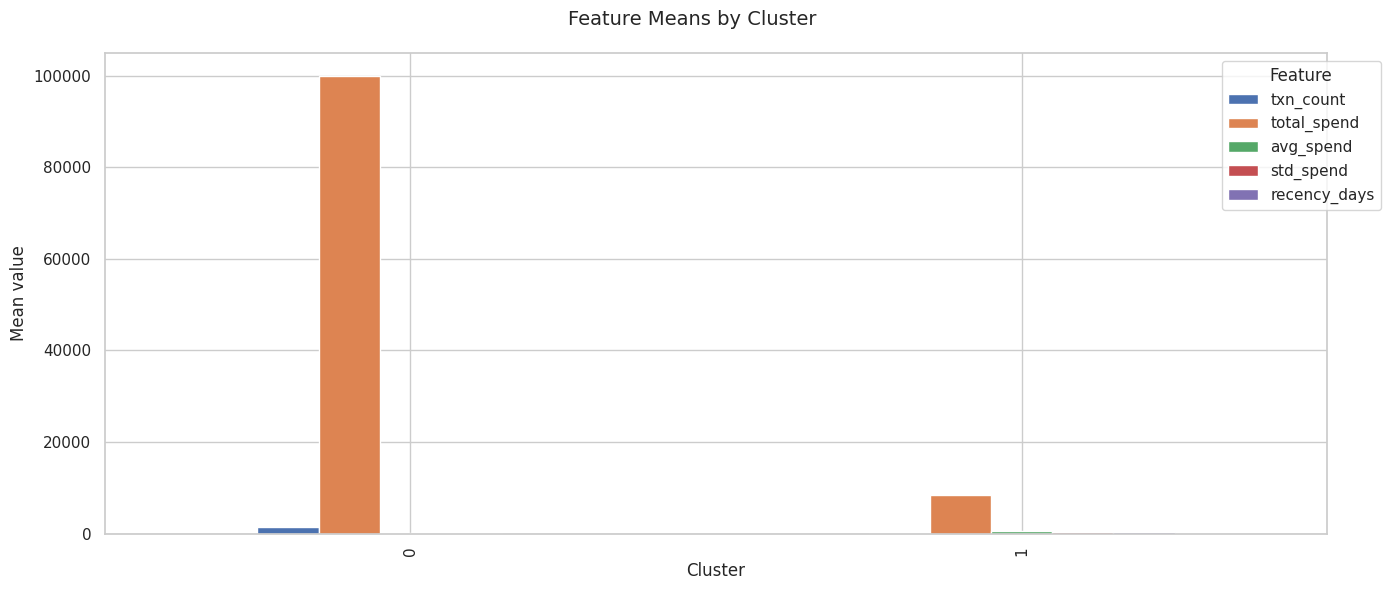

In [28]:
# 2. Bar chart of feature means by cluster
if len(features) > 0:
    cluster_means = agg.groupby('cluster')[features].mean().reset_index()
    cluster_means.set_index('cluster').plot(kind='bar', figsize=(14,6))
    plt.suptitle('Feature Means by Cluster', fontsize=14)
    plt.xlabel('Cluster')
    plt.ylabel('Mean value')
    plt.legend(title='Feature', bbox_to_anchor=(1.05,1))
    plt.tight_layout()
    plt.show()
else:
    print("No numeric features found for bar chart.")


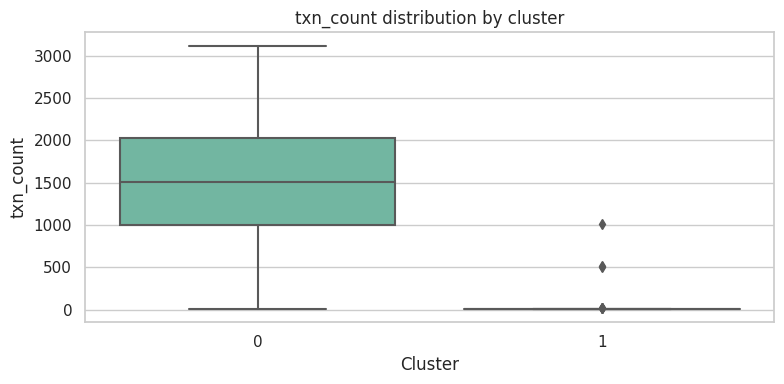

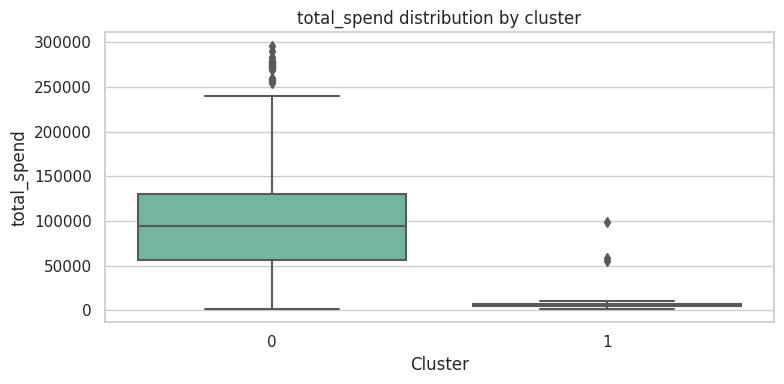

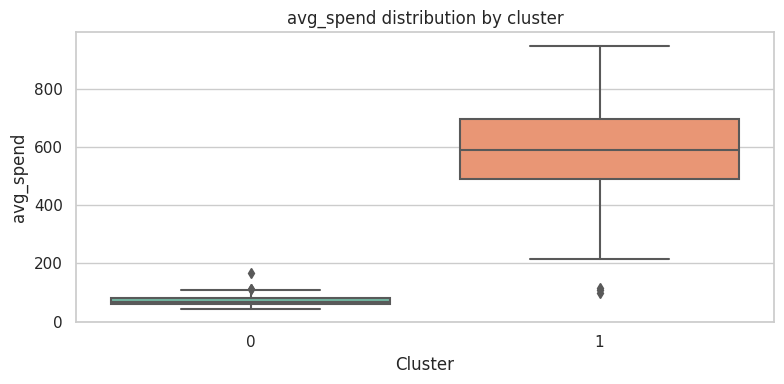

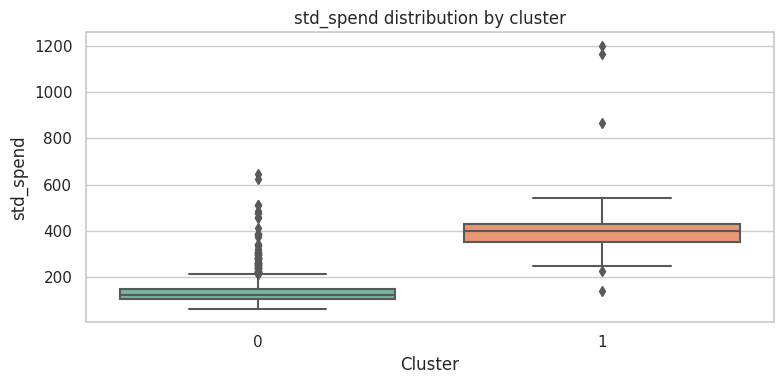

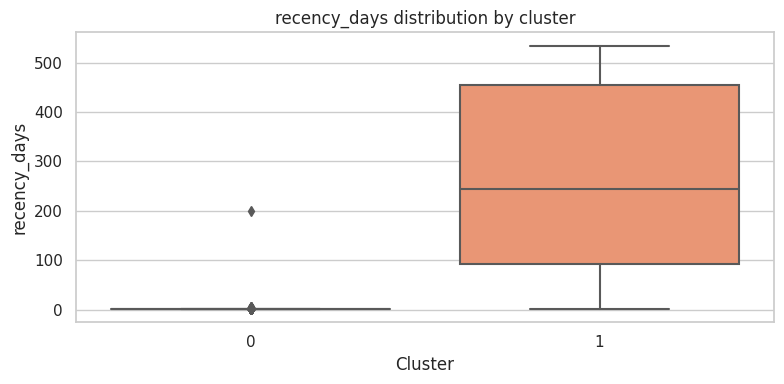

In [29]:
# 3. Boxplots per feature
for f in features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='cluster', y=f, data=agg, palette='Set2')
    plt.title(f'{f} distribution by cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f)
    plt.tight_layout()
    plt.show()


In [37]:
print(agg.columns.tolist())


['customerid', 'txn_count', 'total_spend', 'avg_spend', 'std_spend', 'last_txn', 'recency_days', 'cluster', 'pca1', 'pca2']


In [86]:
# Ensure cc_num exists in both dataframes
if 'cc_num' not in agg.columns:
    agg = agg.rename(columns={'customerid': 'cc_num'})

# Select only demographic columns from df (remove duplicates)
demo_cols = ['cc_num', 'gender', 'city', 'state', 'city_pop', 'dob']
demo_df = df[demo_cols].drop_duplicates(subset='cc_num')

# Merge with agg
agg = agg.merge(demo_df, on='cc_num', how='left')
print("✅ Demographics merged into agg")
agg.head()



✅ Demographics merged into agg


,cc_num,txn_count,total_spend,avg_spend,std_spend,last_txn,recency_days,cluster,pca1,pca2,...,gender_y,city_y,state_y,city_pop_y,dob_y,gender,city,state,city_pop,dob
0,60416207185,1518,85043.47,56.023366,122.632635,2020-06-21 08:54:21,1,0,-0.483145,-0.308017,...,F,Fort Washakie,WY,1645,1986-02-17,F,Fort Washakie,WY,1645,1986-02-17
1,60422928733,1531,105640.20,69.000784,102.681962,2020-06-21 09:19:28,1,0,-0.672308,-0.156950,...,M,North Augusta,SC,46944,1942-04-02,M,North Augusta,SC,46944,1942-04-02
2,60423098130,510,58673.63,115.046333,1202.988005,2020-06-19 01:14:31,3,1,4.424348,3.377119,...,M,Amorita,OK,83,1958-07-28,M,Amorita,OK,83,1958-07-28
3,60427851591,528,59129.61,111.987898,143.310653,2020-06-19 13:06:04,2,0,0.539300,-0.963322,...,M,Burns Flat,OK,2142,1976-06-30,M,Burns Flat,OK,2142,1976-06-30
4,60487002085,496,25160.11,50.726028,65.843969,2020-06-20 15:44:36,1,0,0.318513,-1.767377,...,M,Jackson,MS,233060,1972-08-15,M,Jackson,MS,233060,1972-08-15


In [87]:
# Create Age if DOB present
if 'dob' in agg.columns:
    agg['dob'] = pd.to_datetime(agg['dob'], errors='coerce')
    today = pd.Timestamp.now().normalize()
    agg['age'] = ((today - agg['dob']).dt.days // 365).astype('Int64')


Gender Counts by Cluster:


gender,F,M
cluster,,
0,461,445
1,36,41


Gender Proportions by Cluster:


gender,F,M
cluster,,
0,0.509,0.491
1,0.468,0.532


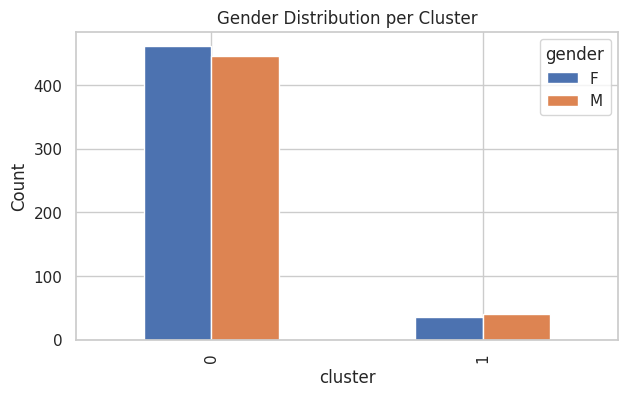

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gender distribution
if 'gender' in agg.columns:
    gender_counts = agg.groupby(['cluster', 'gender'])['cc_num'].count().unstack(fill_value=0)
    gender_prop = gender_counts.div(gender_counts.sum(axis=1), axis=0).round(3)

    print("Gender Counts by Cluster:")
    display(gender_counts)

    print("Gender Proportions by Cluster:")
    display(gender_prop)

    gender_counts.plot(kind='bar', figsize=(7,4))
    plt.title("Gender Distribution per Cluster")
    plt.ylabel("Count")
    plt.show()


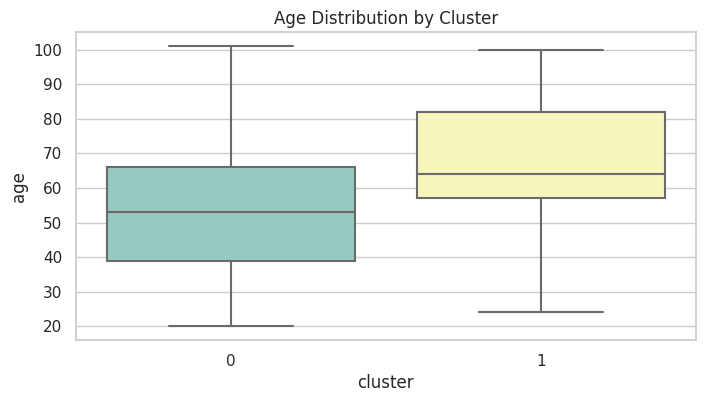

In [80]:
if 'age' in agg.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='cluster', y='age', data=agg, palette='Set3')
    plt.title('Age Distribution by Cluster')
    plt.show()


In [71]:
# 5. Map cluster to transactions
# find id column names
cust_id = 'customerid' if 'customerid' in agg.columns else next((c for c in agg.columns if agg[c].nunique() == agg.shape[0]), 'customerid')
# try common columns in df
txn_id_candidates = ['customerid','cc_num','ccnum','cust_id','card_num','cardnumber','first']
txn_id = next((c for c in txn_id_candidates if c in df.columns), None)
if txn_id is None:
    # try best-effort matching: look for columns with many unique values
    txn_id = next((c for c in df.columns if df[c].nunique() > 1000), None)
if txn_id is None:
    raise KeyError("Can't find customer id column in df. Please tell me the id column name.")
# map (if names differ, try to align)
if cust_id in agg.columns and txn_id in df.columns and cust_id != txn_id:
    df['cluster'] = df[txn_id].map(agg.set_index(cust_id)['cluster'])
else:
    df['cluster'] = df[txn_id].map(agg.set_index(txn_id)['cluster'])

# Top merchants per cluster
if 'merchant' in df.columns:
    top_merchants = (
        df.groupby(['cluster','merchant'])['amt']
          .agg(txns='count', spend='sum')
          .reset_index()
          .sort_values(['cluster','spend'], ascending=[True, False])
    )
    for c in sorted(df['cluster'].dropna().unique()):
        print(f"\nTop merchants for cluster {int(c)}:")
        display(top_merchants[top_merchants['cluster']==c].head(8))
else:
    print("No 'merchant' column in df.")
# Top categories per cluster (if present)
if 'category' in df.columns:
    top_cats = (
        df.groupby(['cluster','category'])['amt']
          .agg(txns='count', spend='sum')
          .reset_index()
          .sort_values(['cluster','spend'], ascending=[True, False])
    )
    for c in sorted(df['cluster'].dropna().unique()):
        print(f"\nTop categories for cluster {int(c)}:")
        display(top_cats[top_cats['cluster']==c].head(8))



Top merchants for cluster 0:


,cluster,merchant,txns,spend
316,0,fraud_Kilback LLC,4396,390051.93
73,0,fraud_Bradtke PLC,2543,301074.39
217,0,fraud_Hackett-Lueilwitz,2565,299554.11
146,0,fraud_Doyle Ltd,2542,298079.60
572,0,"fraud_Schumm, Bauch and Ondricka",2501,296844.20
447,0,fraud_Murray-Smitham,2506,296265.62
494,0,fraud_Rau and Sons,2477,296068.39
196,0,fraud_Goodwin-Nitzsche,2529,295567.26



Top merchants for cluster 1:


,cluster,merchant,txns,spend
1105,1,"fraud_Monahan, Hermann and Johns",2,54509.89
761,1,fraud_Boyer-Haley,3,26556.29
794,1,fraud_Cormier LLC,15,13193.12
1022,1,fraud_Kuhic LLC,10,8208.90
1275,1,fraud_Terry-Huel,8,8071.54
962,1,fraud_Jast Ltd,10,7601.56
700,1,fraud_Ankunding LLC,12,7432.44
762,1,fraud_Boyer-Reichert,9,7296.34



Top categories for cluster 0:


,cluster,category,txns,spend
4,0,grocery_pos,123260,14386898.19
12,0,shopping_pos,116420,9218798.62
11,0,shopping_net,97202,8401559.87
2,0,gas_transport,131399,8338609.64
6,0,home,122924,7162649.69
7,0,kids_pets,112814,6490026.79
0,0,entertainment,93839,6023876.02
8,0,misc_net,63064,5018055.42



Top categories for cluster 1:


,cluster,category,txns,spend
25,1,shopping_net,341,223589.81
22,1,misc_net,223,99653.84
26,1,shopping_pos,252,89194.99
27,1,travel,88,82379.37
18,1,grocery_pos,378,73924.19
21,1,kids_pets,221,13653.37
16,1,gas_transport,260,13122.65
14,1,entertainment,175,12802.54


In [72]:
# 6. Representative customers (closest to centroid)
# ensure X_scaled and kmeans model exist; if not, refit quickly
if 'X_scaled' not in globals():
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(agg[features])
if 'km' not in globals() or not hasattr(km, 'cluster_centers_'):
    km = KMeans(n_clusters=int(agg['cluster'].nunique()), random_state=42, n_init=20).fit(X_scaled)

centers = km.cluster_centers_
closest, _ = pairwise_distances_argmin_min(centers, X_scaled)
print("Representative customers (closest to each centroid):")
for i, idx in enumerate(closest):
    print(f"Cluster {i}: customerid = {agg.iloc[idx].get('customerid', agg.index[idx])}")


Representative customers (closest to each centroid):
Cluster 0: customerid = 289
Cluster 1: customerid = 203


In [74]:
# Label clusters with simple archetype names
def label_row(row):
    if row['total_spend'] > agg['total_spend'].median() and row['txn_count'] > agg['txn_count'].median():
        return "High-Value"
    elif row['total_spend'] < agg['total_spend'].median() and row['txn_count'] > agg['txn_count'].median():
        return "Frequent Low Spender"
    elif row['total_spend'] > agg['total_spend'].median():
        return "Selective Premium"
    else:
        return "Low-Value"

agg['archetype'] = agg.apply(label_row, axis=1)

print("Archetype counts per cluster:")
display(
    agg.groupby(['cluster','archetype'])['cc_num']
       .count()
       .unstack(fill_value=0)
)



Archetype counts per cluster:


archetype,Frequent Low Spender,High-Value,Low-Value,Selective Premium
cluster,,,,
0,29,461,387,29
1,0,0,76,1


In [75]:
# 8. Recommendations mapping
reco_map = {
    'High value - frequent': "VIP program, premium cross-sell, concierge outreach.",
    'High value - recent': "Welcome/retention offers, loyalty enrollment.",
    'Low value - inactive': "Win-back email drip / targeted coupons.",
    'Mid value': "Cross-sell + personalized offers."
}
agg['recommendation'] = agg['archetype'].map(reco_map)
# Show one-row summary per cluster
summary_rows = []
for c in sorted(agg['cluster'].unique()):
    size = int((agg['cluster']==c).sum())
    arche = agg[agg['cluster']==c]['archetype'].mode().iloc[0]
    reco = reco_map.get(arche, "General campaign")
    summary_rows.append({'cluster':int(c),'size':size,'primary_archetype':arche,'recommendation':reco})
cluster_summary_df = pd.DataFrame(summary_rows)
display(cluster_summary_df)


,cluster,size,primary_archetype,recommendation
0,0,906,High-Value,General campaign
1,1,77,Low-Value,General campaign


In [76]:
# 9. Save CSVs and plots
out_dir = '/mnt/data/week3_outputs'
import os
os.makedirs(out_dir, exist_ok=True)

cluster_summary_df.to_csv(os.path.join(out_dir,'cluster_summary.csv'), index=False)
agg.to_csv(os.path.join(out_dir,'customer_aggregates_with_clusters.csv'), index=False)

# save bar chart
plt.figure(figsize=(8,4))
cluster_means.set_index('cluster').plot(kind='bar', figsize=(12,6))
plt.title('Feature Means by Cluster'); plt.tight_layout()
plt.savefig(os.path.join(out_dir,'feature_means_by_cluster.png'), bbox_inches='tight')
plt.close()
# save PCA scatter example
pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=Xp[:,0], y=Xp[:,1], hue=agg['cluster'], palette='tab10', s=50, alpha=0.8)
plt.title('Clusters in PCA space'); plt.tight_layout()
plt.savefig(os.path.join(out_dir,'cluster_pca.png'), bbox_inches='tight')
plt.close()

print(f"Saved CSVs and plots to {out_dir}")


Saved CSVs and plots to /mnt/data/week3_outputs


<Figure size 800x400 with 0 Axes>

In [77]:
# 10. Sanity checks
print("Cluster sizes:")
print(agg['cluster'].value_counts())
if 'X_scaled' in globals():
    print("Silhouette score (scaled features):", round(silhouette_score(X_scaled, agg['cluster']),3))
else:
    print("Note: X_scaled not present — silhouette not computed.")


Cluster sizes:
cluster
0    906
1     77
Name: count, dtype: int64
Silhouette score (scaled features): 0.709
